In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.display import Image

import os, sys, re, datetime, time
from pathlib import Path

from matplotlib import pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use("bmh")
import numpy as np
import pandas as pd
import dask.dataframe as dd
from scipy import stats

from tqdm import tqdm_notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import matplotlib
matplotlib.rcParams["figure.figsize"] = (16, 4)
plt.rcParams["font.family"] = "IPAexGothic"
import logging
logging.basicConfig(level=logging.INFO)

In [17]:
import pymc3 as pm

/Users/yutaro_ikeda/.pyenv/versions/3.6.5/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Section 2

## Grid

In [38]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    grid = np.linspace(0, 1, grid_points)
    prior = np.repeat(5, grid_points)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

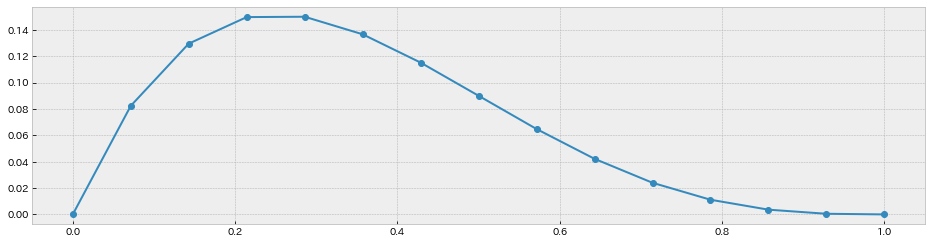

In [39]:
points = 15
h, n = 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-')

## モンテカルロ法

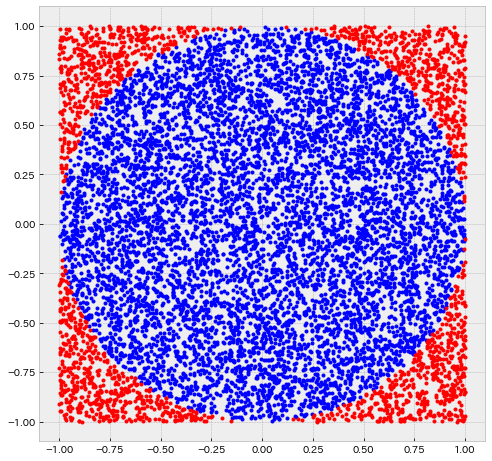

In [72]:
N = 10000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = np.abs((pi - np.pi) / pi) * 100
outside = np.invert(inside)

plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')

### 簡単なMCMC

In [3]:
def metropolis(f, steps=10000):
    samples = np.zeros(steps)
    old_x = f.mean()
    old_prob = f.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = f.pdf(new_x)
        acceptance = new_prob/old_prob
        
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else: 
            samples[i] = old_x
    return samples

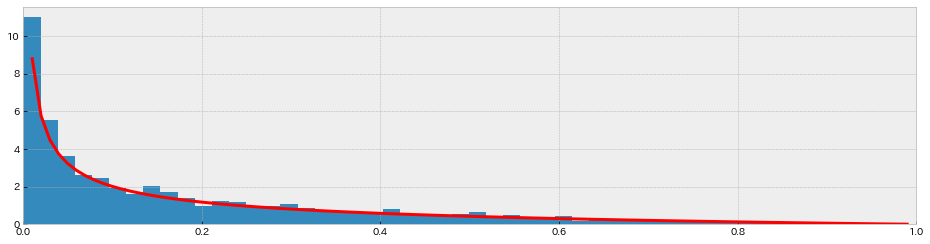

In [75]:
f = stats.beta(0.4, 2)
samples = metropolis(f=f)

x = np.linspace(.01, .99, 100)
y = f.pdf(x)

plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True dist')
plt.hist(samples, bins=50, density=True, label='Estimated dist');

### pymc

In [22]:
n_exp = 40 # 試行回数
theta_real = 0.35 
data = stats.bernoulli.rvs(p=theta_real, size=n_exp)
print(data)

[0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 1 1 0 0 1 0 0 1 1 0 1
 1 1 0]


In [31]:
with pm.Model() as model:
    theta = pm.Beta('theta', alpha=1, beta=1)
    y = pm.Bernoulli('y', p=theta, observed=data)
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start, njobs=4)

logp = -27.726, ||grad|| = 5: 100%|██████████| 7/7 [00:00<00:00, 1703.12it/s]
INFO:pymc3:Multiprocess sampling (4 chains in 4 jobs)
INFO:pymc3:Metropolis: [theta]
Sampling 4 chains: 100%|██████████| 6000/6000 [00:00<00:00, 6638.34draws/s]
INFO:pymc3:The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117213cf8>,
      dtype=object)

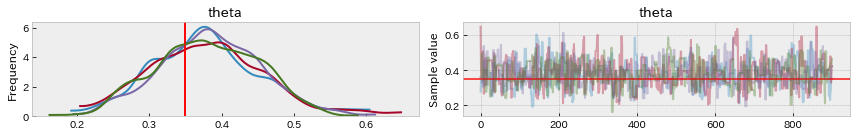

In [32]:
burnin = 100
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta': theta_real})

In [33]:
pm.gelman_rubin(chain)

{'theta': 1.0001040190763584}

In [34]:
pm.summary(chain)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
theta,0.380704,0.074345,0.002679,0.239724,0.51869,753.008157,1.000104


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x117688e80>,
      dtype=object)

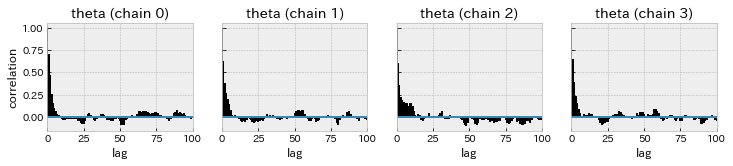

In [35]:
pm.autocorrplot(chain)

In [36]:
pm.effective_n(chain)

{'theta': 753.0081572014177}

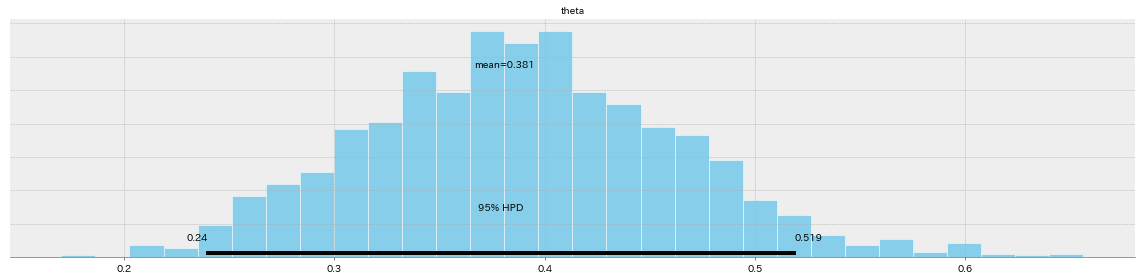

In [37]:
pm.plot_posterior(chain)

# 演習

## 1

In [63]:
def posterior_grid(grid_points=100, heads=6, tosses=9):
    grid = np.linspace(0, 1, grid_points)
    prior = (grid <= 0.8).astype(int)
    likelihood = stats.binom.pmf(heads, tosses, grid)
    unstd_posterior = likelihood * prior
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

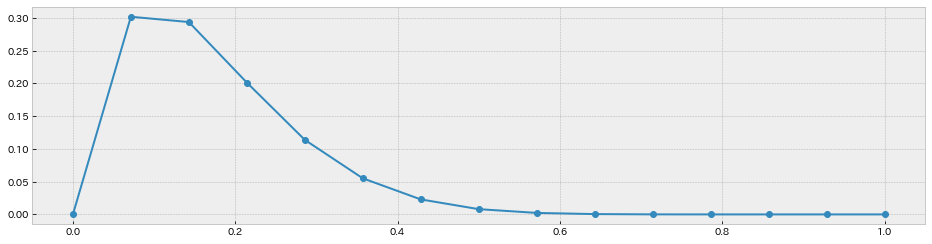

In [64]:
points = 15
h, n = 1, 10
grid, posterior = posterior_grid(points, h, n)
plt.plot(grid, posterior, 'o-')

## 2

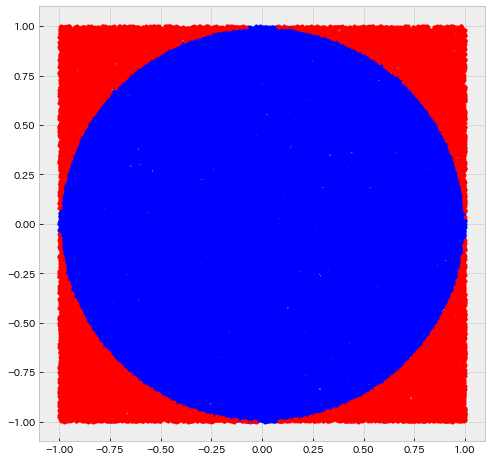

In [73]:
N = 100000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = np.abs((pi - np.pi) / pi) * 100
outside = np.invert(inside)

plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')

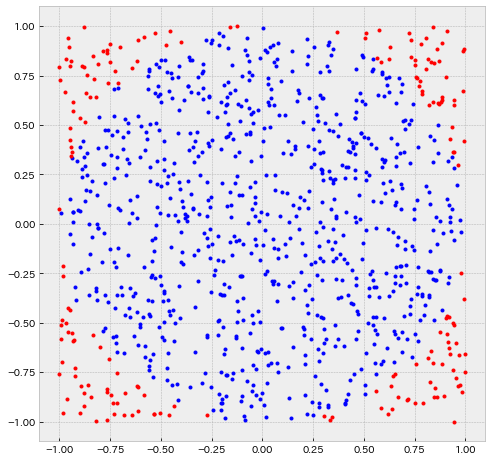

In [74]:
N = 1000
x, y = np.random.uniform(-1, 1, size=(2, N))
inside = (x**2 + y**2) <= 1
pi = inside.sum()*4/N
error = np.abs((pi - np.pi) / pi) * 100
outside = np.invert(inside)

plt.figure(figsize=(8, 8))
plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')

## 3

In [76]:
def metropolis(f, steps=10000):
    samples = np.zeros(steps)
    old_x = f.mean()
    old_prob = f.pdf(old_x)
    
    for i in range(steps):
        new_x = old_x + np.random.normal(0, 0.5)
        new_prob = f.pdf(new_x)
        acceptance = new_prob/old_prob
        
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else: 
            samples[i] = old_x
    return samples

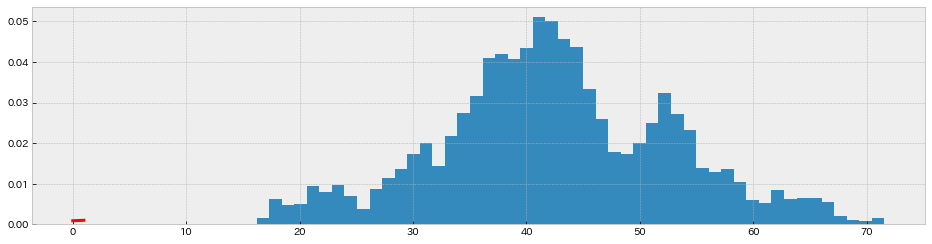

In [83]:
# f = stats.beta(0.4, 2)
f = stats.norm(loc=50, scale=20)
samples = metropolis(f=f)

x = np.linspace(.01, .99, 100)
y = f.pdf(x)

plt.plot(x, y, 'r-', lw=3, label='True dist')
plt.hist(samples, bins=50, density=True, label='Estimated dist');